In [2]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.6 MB/s eta 0:00:00


Loading data...
Fitting preprocessing...
Train shape: (1022825, 9), Test shape: (255707, 9)
Cluster 0: 115379 samples
Cluster 1: 250269 samples
Cluster 2: 218538 samples
Cluster 3: 236318 samples
Cluster 4: 202321 samples
Grid search complete. Best params per cluster: {np.int32(0): {'max_depth': 20, 'n_estimators': 100}, np.int32(1): {'max_depth': 20, 'n_estimators': 100}, np.int32(2): {'max_depth': 20, 'n_estimators': 100}, np.int32(3): {'max_depth': 20, 'n_estimators': 100}, np.int32(4): {'max_depth': 20, 'n_estimators': 100}}
Hybrid Model Performance: MAE=34.04 RMSE=78.46 R2=0.9464
Results saved to results.txt and plots saved as PNG files.


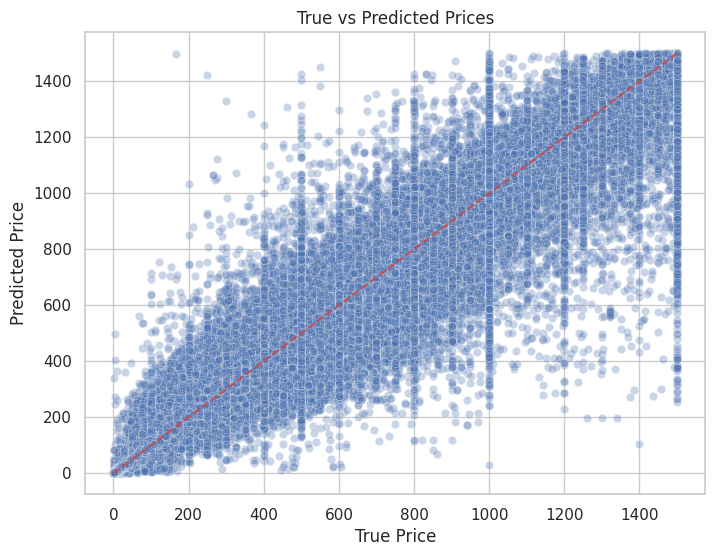

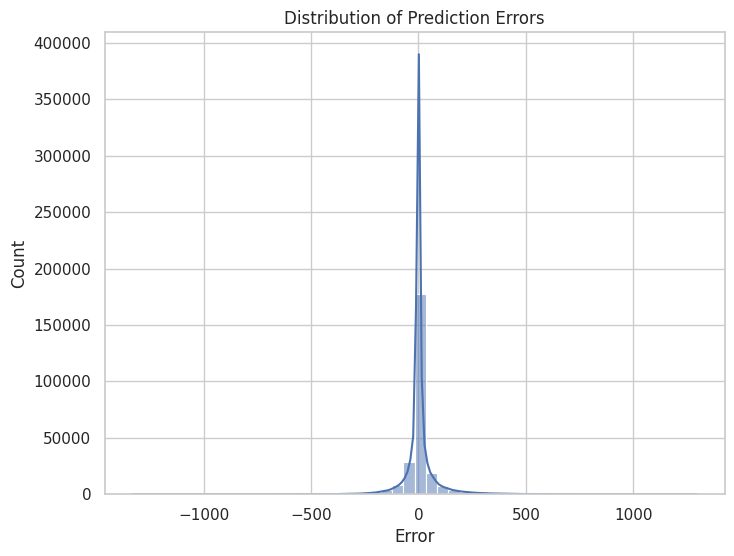

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration
DATA_PATH = 'wfp_food_prices_database.csv'
N_CLUSTERS = 5            # KMeans clusters
TEST_SIZE = 0.2
RANDOM_STATE = 42

# 1. Load data
print('Loading data...')
df = pd.read_csv(DATA_PATH, low_memory=False)

# 2. Preprocessing
# Drop irrelevant columns
drop_cols = ["mp_commoditysource", "adm0_name", "adm1_name", "mkt_name", "cur_name", "pt_name", "um_name"]
df = df.drop(columns=drop_cols, errors='ignore')
# Filter valid prices
df = df[df['mp_price'] > 0].reset_index(drop=True)
# Remove outliers using IQR
Q1 = df['mp_price'].quantile(0.25)
Q3 = df['mp_price'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.0 * IQR, Q3 + 1.0 * IQR
df = df[(df['mp_price'] >= lower) & (df['mp_price'] <= upper)].reset_index(drop=True)

# Feature engineering
# Cyclical month encoding
df['mp_month_sin'] = np.sin(2 * np.pi * df['mp_month'] / 12)
df['mp_month_cos'] = np.cos(2 * np.pi * df['mp_month'] / 12)
# Regional mean price
df['adm1_mean_price'] = df.groupby('adm1_id')['mp_price'].transform('mean')

# 3. Prepare features and target
features = ['adm1_id', 'cm_id', 'cur_id', 'pt_id', 'um_id',
            'mp_month_sin', 'mp_month_cos', 'mp_year', 'adm1_mean_price']
target = 'mp_price'
X_raw = df[features].copy()
y_raw = df[target]
# Convert ID columns to string for TargetEncoder
id_cols = ['adm1_id', 'cm_id', 'cur_id', 'pt_id', 'um_id']
for col in id_cols:
    X_raw[col] = X_raw[col].astype(str)
# Log1p transform with clipping to 99th percentile
clip_val = y_raw.quantile(0.99)
y_log = np.log1p(y_raw.clip(lower=1e-6, upper=clip_val))

# 4. Preprocessing pipeline
numeric_feats = ['mp_month_sin', 'mp_month_cos', 'mp_year', 'adm1_mean_price']
cat_feats = id_cols
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', TargetEncoder(min_samples_leaf=10, smoothing=5), cat_feats)
])
pipeline = Pipeline([('pre', preprocessor)])
print('Fitting preprocessing...')
X_processed = pipeline.fit_transform(X_raw, y_log)

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_log, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

# 6. Clustering on train set
dist_clusters = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
train_clusters = dist_clusters.fit_predict(X_train)
test_clusters = dist_clusters.predict(X_test)

# 7. Grid search and train per-cluster
param_grid = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
cluster_models = {}
best_params = {}
for cid in np.unique(train_clusters):
    mask = train_clusters == cid
    X_c, y_c = X_train[mask], y_train[mask]
    print(f'Cluster {cid}: {X_c.shape[0]} samples')
    gs = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
                      param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    gs.fit(X_c, y_c)
    cluster_models[cid] = gs.best_estimator_
    best_params[cid] = gs.best_params_
print('Grid search complete. Best params per cluster:', best_params)

# 8. Predict and evaluate hybrid model
y_pred_log = np.zeros_like(y_test, dtype=float)
for cid in np.unique(test_clusters):
    mask = test_clusters == cid
    y_pred_log[mask] = cluster_models[cid].predict(X_test[mask])
y_true = np.expm1(y_test)
y_pred = np.expm1(y_pred_log)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print('Hybrid Model Performance:', f'MAE={mae:.2f}', f'RMSE={rmse:.2f}', f'R2={r2:.4f}')

# 9. Save statistical results
with open('results.txt', 'w') as f:
    f.write('Hybrid Model Performance:\n')
    f.write(f'MAE: {mae:.2f}\n')
    f.write(f'RMSE: {rmse:.2f}\n')
    f.write(f'R2: {r2:.4f}\n\n')
    f.write('Best params per cluster:\n')
    for cid, params in best_params.items():
        f.write(f'Cluster {cid}: {params}\n')

# 10. Visualizations
sns.set(style='whitegrid')

# Scatter plot: True vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()],[y_true.min(), y_true.max()], 'r--')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('True vs Predicted Prices')
plt.savefig('true_vs_pred.png')

# Histogram: Prediction Errors
errors = y_true - y_pred
plt.figure(figsize=(8,6))
sns.histplot(errors, bins=50, kde=True)
plt.xlabel('Error')
plt.title('Distribution of Prediction Errors')
plt.savefig('error_distribution.png')

print('Results saved to results.txt and plots saved as PNG files.')

